# Volatility Musings

For future reference, we have just finished the brief test of the implementation of the Black-Scholes valuation and verified that is seems to work. However, as we know, the model does not properly represent reality: it assumes constant drift and volatility, for example. Yet, there are things like the volatility smile, smirk, etc.; and the general implied volatility surface (that is, a 3D surface plot of implied volatility as a function of time to maturity and money-ness) is not flat.

Here, we will consider volatility to not be constant, but, rather, to follow a stochastic model. 

To learn, we will use the model proposed in Chapter 23 of the Hull book, that is, a GARCH(1,1) based model. The GARCH(1,1) is introduced as a way to estimate the volatility $\sigma_n$ as a function of the returns $u_n$. It suggests that
\begin{equation*}
\sigma_n^2 = \alpha u_{n-1}^2 + \beta \sigma_{n-1}^2 + \gamma V_L,
\end{equation*}
where $\alpha+\beta+\gamma=1$ and $V_L$ corresponds to an long-run average level of the square of the volatility.

A few assumptions that were used were that the drift on the returns is very small compared to the volatility, so that the returns can be used as is, and, therefore, are assumed to be zero-mean Gaussians with variance given by the square of the volatility (that is, $u_n \sim \mathcal{N}(0,\sigma_n^2)$). Therefore, the random variable $u_n^2$ has expected value $\mathbb{E}[u_n^2]=\sigma_n^2$. Recalling that the fourth moment of a zero-mean Gaussian is $\mathbb{E}[X^4] = 3\sigma^4$, we can also compute $Var[u_n^2] = 2\sigma^4$. Let $V$ denote the variance of the underlying asset price, that is, the square of the volatility $\sigma$, it can, from these, be shown that the GARCH(1,1) equation above corresponds to a general form of the Ornstein–Uhlenbeck as
\begin{equation*}
dV = \gamma\left(V_L - V\right) dt + \sqrt{2}\alpha V dW,
\end{equation*}
where $dW$ is a standard Wiener process. Note that this is a mean-reverting process, with mean at $V_L$.

So, for instance, we can look at some past data, estimate parameters $\alpha, \beta, \gamma,$ and $V_L$, and use those to perform Monte Carlo simulations of evolution of the asset price. These simulations could allow us to have a better understanding, for instance, of the value, at maturity, of an option on the asset.

Let's workshop this idea with some real data. We will look at daily values, for which we hope the volatility is more pronouced than the drift signal, and use an optimizer to do maximum likelihood estimation of the parameters.

Start by loading the data of interest (obtained from Hull).

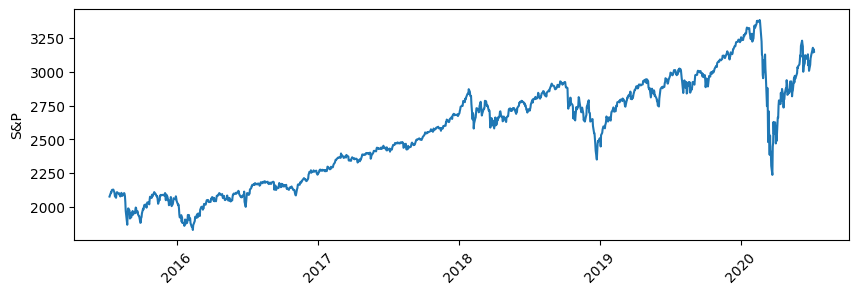

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Older data
# data = pd.read_excel(io='../../useful_resources/hull_data/ForEx_and_IndexData.xls',
#                      sheet_name='Indices',
#                      usecols=[0, 1, 3, 4, 6, 7, 9, 10])

# Newer S&P only
data = pd.read_excel(io='../../useful_resources/hull_data/GARCHCALCS11thS&P500.xls',
                     sheet_name='Basic GARCH',
                     skiprows=[1,],
                     nrows=1259,
                     usecols=[0, 1])

fig, axes = plt.subplots(len(data.columns) // 2, 1, sharex='col', figsize=(10, 3))
try:
    axes[-1].tick_params(axis='x', rotation=45)
except TypeError:
    axes.tick_params(axis='x', rotation=45)

for i, col in enumerate(data.iloc[:, 1::2].columns):
    try:
        axes[i].plot(pd.to_datetime(data.iloc[:, 2*i]), data[col])
        axes[i].set_ylabel(col)
    except TypeError:
        axes.plot(pd.to_datetime(data.iloc[:, 2*i]), data[col])
        axes.set_ylabel(col)

For now, let's stick with the S&P 500 as an example. We will also take a look at both the linear returns and the log returns. If $S_t$ is the price of the stock at time $t$, the linear return is given by 
\begin{equation*}
R_t = \frac{S_t - S_{t-1}}{S_{t-1}} = \frac{S_t}{S_{t-1}} - 1,
\end{equation*}
while the log-return is given by
\begin{equation*}
r_t = \log\left(\frac{S_t}{S_{t-1}}\right) = \log\left(1 + R_t\right)
\end{equation*}

Under the assumption that $\left|R_t\right|$ is very small, we can use the fact that the Taylor expansion of $\log(x)$ around $x_0=1$ gives $\log(x)\approx x-1$ to show that $r_t \approx R_t$.

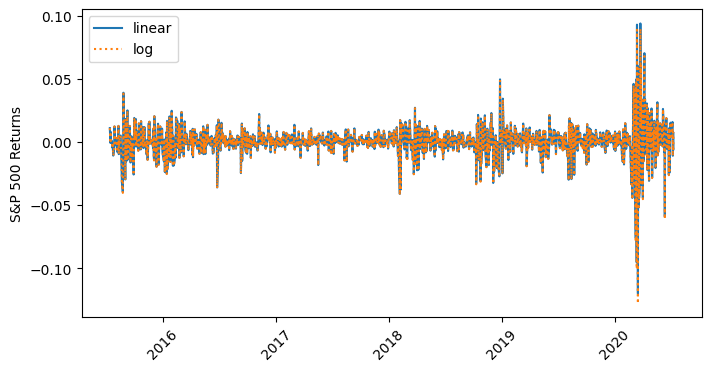

In [2]:
sp500 = data['S&P'].to_numpy()  # data['S&P 500'].to_numpy()  # 

linear_returns = np.diff(sp500) / sp500[:-1]
log_returns = np.diff(np.log(sp500))

fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(data['Date'].iloc[1:], linear_returns, label='linear')
axes.plot(data['Date'].iloc[1:], log_returns, linestyle=':', label='log')
axes.set_ylabel('S&P 500 Returns')
axes.tick_params(axis='x', rotation=45)
_ = axes.legend()

The plot above shows the volatility clustering that the GARCH model tries to address. We will now use estimate the model parameters using maximum likelihood estimation (MLE), with an additional important assumption: volatility is unaffected by non-trading days, that is, when a the return from a Friday to a Monday is considered as going from $r_t$ to $r_{t+1}$, instead of $r_{t+3}$ (with $t+1$ being Saturday and $t+2$ Sunday). 

At any given day $i$, the likelihood of the observed return $u_i$ is given by the usual zero-mean Gaussian PDF:
\begin{equation*}
\mathcal{L}(u_i|\sigma_i) = \frac{1}{\sqrt{2\pi}\sigma_i} \exp\left(-\frac{u_i^2}{2\sigma_i^2}\right)
\end{equation*}

Ignoring constant terms, we wish to maximize the log-likelihood, given by
\begin{equation*}
\log(\mathcal{L}(\{u_i\})) = \sum\limits_{i} \left[-\log(\sigma_i) - \frac{u_i^2}{2\sigma_i^2}\right]
\end{equation*}

By replacing $\nu_i = \sigma_i^2$, we can obtain a nicer expression to work with:
\begin{equation*}
\log(\mathcal{L}(\{u_i\})) = \sum\limits_{i} \left[-\log(\nu_i) - \frac{u_i^2}{\nu_i}\right]
\end{equation*}

Let's create this a negative log-likelihood function, which we wish to minimize.

In [3]:
def negative_log_likelihood(params: np.ndarray, returns: np.ndarray, scaling_factor: float = 1.0e-03) -> float:
    """
    Function that computes the negative of the log-likelihood of the returns provided the GARCH parameters, which should
    be passed as an array of shape (3,)

    Args:
        params: array of shape (3,) corresponding to [alpha, beta, gamma*V_L]
        returns: array of returns to be used in the GARCH evolution
        scaling_factor: factor to be used for scaling the return and avoid exploding gradients

    Returns:
        negative of the log-likelihood
    """
    # Get the main parameters
    alpha, beta, gamma_V_L = params

    # Initialize the volatility and negative log likelihood
    neg_log_like = 0
    v_i = returns[0] * returns[0]  # 0  # gamma_V_L / (1 - alpha - beta)  # 

    for u_i in returns[1:].tolist():
        v_i = gamma_V_L + (alpha * u_i * u_i) + (beta * v_i)
        neg_log_like += np.log(v_i) + (u_i * u_i / v_i)
    
    return scaling_factor * neg_log_like  # includind small factor here to avoid exploding gradients

Now, let's minimize this function with the constraint that $\alpha+\beta<1$ with an uninformative guesses for $\alpha$ and $\beta$.

In [4]:
from scipy.optimize import minimize, Bounds, LinearConstraint

# Prepare initial "estimate" for V_L 
v_L_0 = np.var(linear_returns)  # Assuming sample variance, as this is just an initial guess

# Choose optimization method and scaling factor to avoid exploding gradients
method = 'COBYQA'
scaling_factor = 1  # 1.0e-06

# Set bounds and constraints
bounds = Bounds(lb=1.0e-08 * np.ones(shape=(3,)),
                ub=np.array([1., 1., np.inf]))
constraints = LinearConstraint(A=np.array([[1, 1, 0]]),
                               lb=1.0e-08, ub=1.)

# Keep track of the best result so far
mle_best = {'Log': {'result': None, 'neg_log_like': np.inf},
            'Linear': {'result': None, 'neg_log_like': np.inf}}

# Optimize considering a variety of initial guesses
for alpha0 in [0.01, 0.2]:
    for beta0 in [0.05, 0.25, 0.5, 0.75]:

        if alpha0 + beta0 >= 1:
            continue

        # Set the other parameter
        gamma0 = (1. - alpha0 - beta0)
        x0 = np.array([alpha0, beta0, gamma0 * v_L_0])

        # Minimize
        log_params = minimize(fun=negative_log_likelihood, x0=x0.copy(),
                              args=(log_returns, scaling_factor),
                              bounds=bounds,
                              constraints=constraints,
                              method=method
                              )
        linear_params = minimize(negative_log_likelihood, x0=x0.copy(),
                                 args=(linear_returns, scaling_factor),
                                 bounds=bounds,
                                 constraints=constraints,
                                 method=method
                                 )
        
        # See if we are better than before
        if log_params.fun < mle_best['Log']['neg_log_like']:
            mle_best['Log']['result'] = log_params
            mle_best['Log']['neg_log_like'] = log_params.fun
        if linear_params.fun < mle_best['Linear']['neg_log_like']:
            mle_best['Linear']['result'] = linear_params
            mle_best['Linear']['neg_log_like'] = linear_params.fun

# Display results
for style, results in mle_best.items():
    alpha, beta, gamma_V_L = results['result'].x
    gamma = 1. - alpha - beta
    v_L = gamma_V_L / gamma
    sigma_L = 100 * np.sqrt(v_L)  # in percentage per day
    neg_log_like = results['result'].fun
    number_it = results['result'].nit
    print(f'{style}-returns terminated after {number_it} iterations')
    print(f'alpha={alpha:1.5f}, beta={beta:1.5f}, gamma={gamma:1.5f}, V_L={v_L:1.3e}, sigma_L={sigma_L:1.5f}% per day')
    print(f'Scaled negative log-likelihood = {neg_log_like:1.5f}')
    print('=' * 85)

Log-returns terminated after 50 iterations
alpha=0.98789, beta=0.00000, gamma=0.01211, V_L=8.254e-07, sigma_L=0.09085% per day
Scaled negative log-likelihood = -12946.88255
Linear-returns terminated after 43 iterations
alpha=0.98789, beta=0.00000, gamma=0.01211, V_L=8.255e-07, sigma_L=0.09086% per day
Scaled negative log-likelihood = -12946.46051


These values seem off... usually, from what I have seem online and on Hull's book, we expect lower values of $\alpha\in [0.03, 0.25]$ and higher values of $\beta\in[0.5, 0.95]$. I have tried using the example from Hull and were not able to get the values they got, but, at the same time, the values I have here yield a lower negative log-likelihood than those from the book...

In [5]:
book_likelihood = negative_log_likelihood(params=np.array([0.223793, 0.747577, 0.0000039818]),
                                          returns=linear_returns,
                                          scaling_factor=scaling_factor)